<a href="https://colab.research.google.com/github/vinayshanbhag/Colaboratory/blob/master/Convolution_Kernels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>Introduction</h3>
  <p>  
  A kernel or convolution matrix is a small matrix used for filtering images. This is achieved by performing a convolution between the kernel and image. Convolution is done by multiplying a pixel's value with the corresponding value in the kernel and assigning the sum of these products to the central pixel. The output of this operation is a filtered image. 
  </p>
  
  <p>Load an image from wikimedia. To keep it simple, convert the image to grayscale.</p>

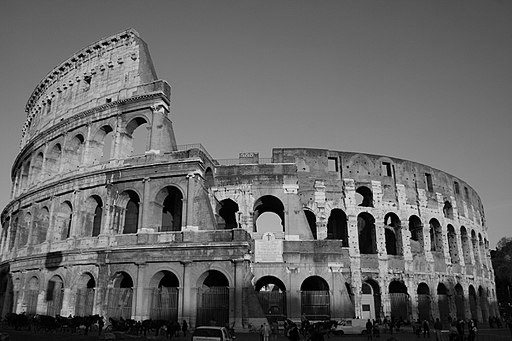

In [2]:
from PIL import Image, ImageOps
import requests
from io import BytesIO
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

url="https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Colosseo_2008.jpg/512px-Colosseo_2008.jpg"
#url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Sacred_lotus_Nelumbo_nucifera.jpg/512px-Sacred_lotus_Nelumbo_nucifera.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("L")
img

<h3>Convert image to pixel array</h3>
<p>To perform convolution the image needs to be a 2D array of pixel values. We do that using numpy. The resulting numpy array is a 2D matrix of this shape.</p>

In [3]:
import numpy as np
orig_image = np.array(img)
print("Original image shape - ",orig_image.shape)
orig_image

Original image shape -  (341, 512)


array([[84, 85, 85, ..., 74, 74, 73],
       [85, 86, 86, ..., 74, 74, 74],
       [86, 87, 87, ..., 74, 74, 74],
       ...,
       [15, 29, 40, ..., 20, 25, 17],
       [12, 21, 30, ..., 20, 25, 21],
       [ 2,  7, 20, ..., 18, 23, 22]], dtype=uint8)

<h3>Box Blur Kernel</h3>
  <p>Start with a simple box blur kernel.</p>
  $$\begin{bmatrix} \frac{1}{9} & \frac{1}{9}  & \frac{1}{9} \\ \frac{1}{9} & \frac{1}{9}  & \frac{1}{9} \\ \frac{1}{9} & \frac{1}{9}  & \frac{1}{9} \end{bmatrix}$$

<p>This kernel will average the pixel values from original image. We will assign the sum of the products to the central pixel. For example, if we convolve this kernel with the top left corner of the image, then the resulting value for the central pixel is as shown below. Note that it is not a traditional matrix product, but a Hadamard or entrywise product.</p>

\begin{equation*}
  \begin{bmatrix}
    84&85&85\\
    85&86&86\\
    86&87&87
  \end{bmatrix}
  \circ
  \begin{bmatrix}
    \frac{1}{9} & \frac{1}{9}  & \frac{1}{9} \\ \frac{1}{9} & \frac{1}{9}  & \frac{1}{9} \\ \frac{1}{9} & \frac{1}{9}  & \frac{1}{9}
  \end{bmatrix}
  =
  \frac{84}{9}+\frac{85}{9} ... + \frac{87}{9} = 85.66
\end{equation*}


In [0]:
box_blur_kernel = np.ones((3,3))/9

In [5]:
print("Pixels from top left corner of the original image")
orig_image[:3,:3]
print("\n\nBox blur kernel")
box_blur_kernel
print(f"\n\nPixel value of central pixel after convolution {(orig_image[:3,:3]*box_blur_kernel).sum():0.2f}")

Pixels from top left corner of the original image


array([[84, 85, 85],
       [85, 86, 86],
       [86, 87, 87]], dtype=uint8)



Box blur kernel


array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]])



Pixel value of central pixel after convolution 85.67


<h3>Convolution</h3>
<p>Repeat the above process by sliding the kernel over original image from left to right and top to bottom. The resulting value from each convolution is assigned to the central pixel in output (filtered) image.</p>

In [6]:
rows, columns = orig_image.shape
output_image = np.zeros((rows,columns))
kernel_width, kernel_height = box_blur_kernel.shape
for row in range(rows-kernel_height):
  for col in range(columns - kernel_width):
    block = orig_image[row:row+kernel_height,col:col+kernel_width]
    val = (block*box_blur_kernel).sum()
    output_image[row + kernel_height//2, col + kernel_width//2] = val

output_image

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 85.66666667, 86.        , ..., 74.        ,
         0.        ,  0.        ],
       [ 0.        , 86.33333333, 86.66666667, ..., 74.11111111,
         0.        ,  0.        ],
       ...,
       [ 0.        , 24.55555556, 32.11111111, ..., 22.66666667,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

<h3>Display filtered image</h3>
<p>Convert the filtered image pixel array to an Image and display.</p>

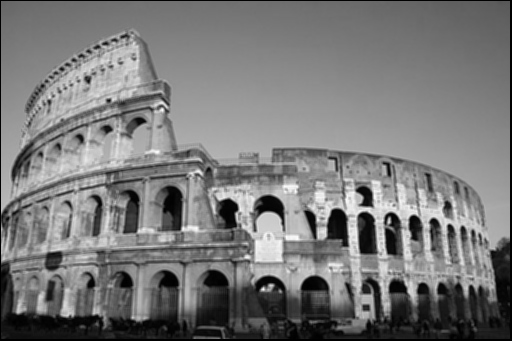

In [8]:
from numpy import interp
Image.fromarray(np.uint8(interp(output_image,[output_image.min(),output_image.max()],[0,255])))

<h3>Observations</h3>

* The kernel size must be odd so that it has a center. e.g. 3x3, 7x7 etc
* If the sum of all elements in the kernel add up to 1, the resulting image will have same brightness as original. A sum smaller than 1, results in darker image.
* This process loses pixels around the edge. e.g. The 3x3 kernel above resulted in a 1 pixel loss around the entire image. A 5x5 kernel would lose 2 pixels all around the edges and so on. One way to fix this is by extending the nearest border pixels as far as necessary to provide values for the convolution.




<h3>Other Kernels</h3>
<p>To simplify experimenting with other kernels, wrap this into a function.</p>

In [0]:
def convolve(channel, kernel):
  """Convolve a single image channel with kernel"""
  rows, columns = channel.shape
  output = np.zeros((rows,columns))
  k_w, k_h = kernel.shape
  for row in range(rows-k_h):
    for col in range(columns - k_w):
      block = channel[row:row+k_h,col:col+k_w]
      val = (block*kernel).sum()
      output[row+k_h//2,col+k_w//2]= val
  return output 


def display_image(img):
  """Return an Image from a 2D array of pixel values"""
  from numpy import interp
  return Image.fromarray(np.uint8(interp(img,[img.min(),img.max()],[0,255])))

<h3>Create some filters</h3>

In [0]:
identity_kernel = np.array([[0,0,0],
                     [0,1,0],
                     [0,0,0]
                    ])

box_blur_kernel = np.ones((7,7))/49 


outline_kernel = np.array([[-1,-1,-1],
                           [-1, 8,-1],
                           [-1,-1,-1]
                          ])

<h4>Identity</h4>
<p>Returns original image, but we lose a pixel around the edge due to the convolution process.</p>

\begin{bmatrix} 0 & 0  & 0 \\ 0 & 1  & 0 \\ 0 & 0  & 0 \end{bmatrix}

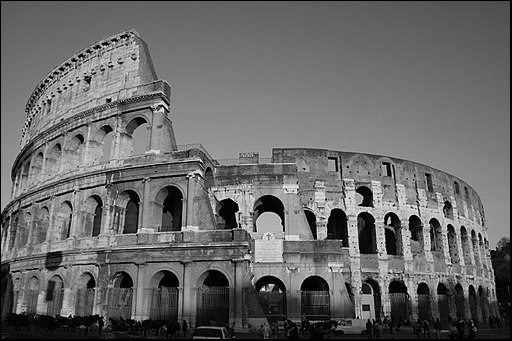

In [11]:
display_image(convolve(orig_image, identity_kernel))

<h4>Box Blur 7x7 kernel</h4>
<p>Same as the previous box blur, but with a larger (7x7) kernel.</p>

\begin{bmatrix} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \\  \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \\  \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \\  \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \\  \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \\  \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \\  \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \frac{1}{49} \\ \end{bmatrix}

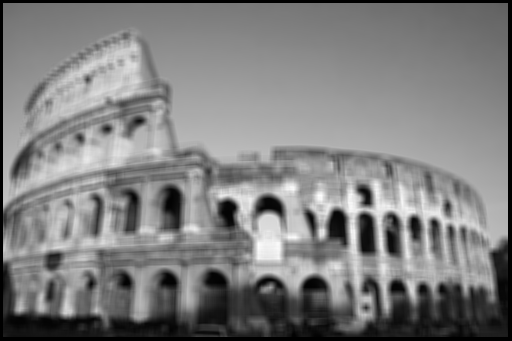

In [12]:
display_image(convolve(orig_image, box_blur_kernel))

<h4>Outline Kernel</h4>
<p></p>

\begin{bmatrix} -1 & -1  & -1 \\ -1 & 8 & -1 \\ -1 & -1  & -1 \end{bmatrix}

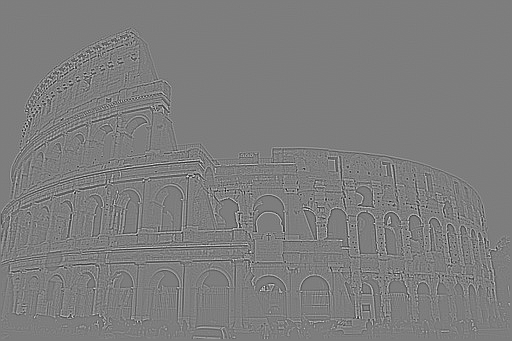

In [13]:
display_image(convolve(orig_image, outline_kernel))

<h3>Extend this to color images</h3>
<p>The same concept can be applied to color images. In this case the convolution is performed for each R,G,B channel in image</p>

In [0]:
def filter_image(img, kernel):
  """Apply filter(kernel) to image(img) and return filtered image"""
  if len(img.shape) == 2:
    return convolve(img, kernel)
  elif len(img.shape) == 3:
    rows, columns, channels = img.shape
    output = np.zeros((rows,columns, channels))
    for channel in range(channels):
      output[...,channel] = convolve(img[...,channel], kernel)
    return output
  else:
    return None


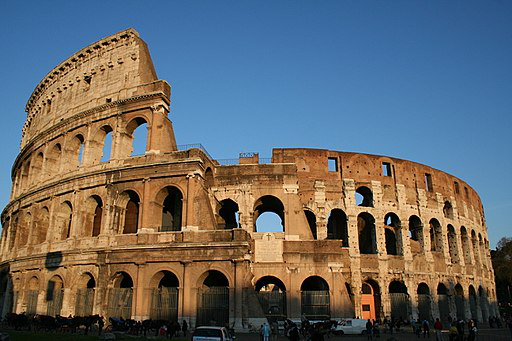

In [15]:
color_image = Image.open(BytesIO(response.content))
color_image

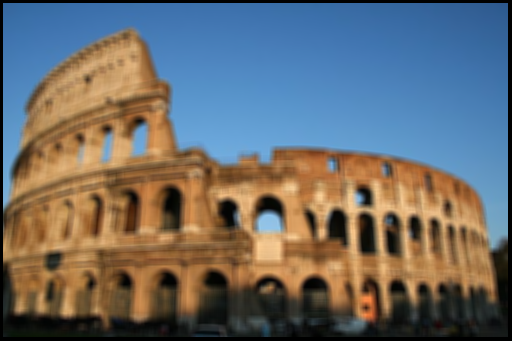

In [16]:
display_image(filter_image(np.array(color_image),
                           box_blur_kernel
                          )
             )